# Programming Assignment: Fruit Guard Pro - Visualizing AI Food Quality Inspection

## Introduction

In this notebook, you'll explore a series of hands-on steps that build your understanding of how vision models process, interpret, and even create images. You'll start by examining how convolutional layers capture local features and progressively integrate them into more abstract representations as the receptive field expands. From there, you'll investigate ways to uncover what parts of an image most influence a model's predictions, and finally, you'll move into methods that generate entirely new images from scratch.

By working through the exercises, you will:

- Analyze how feature maps evolve through deeper convolutional layers and how receptive fields grow.
- Apply pixel-level interpretability with saliency maps to highlight influential image areas.
- Use region-focused techniques like Class Activation Mapping (CAM) to visualize high-level feature importance.
- Experiment with generative approaches such as diffusion models to transform noise into coherent images.

This progression will give you both an internal view of a model's decision process and an external ability to guide or control the outputs it produces.

-------------


# Table of Contents
- [ 1 - Imports](#1)
- [ 2 - Fruits Dataset](#2)
- [ 3 - Fruit Guard Pro Pre Trained Model](#3)
- [ 4 - Feature Hierarchy Visualization](#4)
  - [ Exercise 1](#ex01)
- [ 5 - Feature Map Strip](#5)
  - [ Exercise 2](#ex02)
- [ 6 - Saliency Map](#6)
  - [ Exercise 3](#ex03)
- [ 7 - Simplified Class Activation Map (CAM)](#7)
  - [ Exercise 4](#ex04)
- [ 8 - Comparison of Interpretability Techniques](#8)
- [ 9 - Optional: Text-to-Image Generation](#9)
  - [ 9.1 - Optional Exercise: Text-to-Image Generation](#9-1)
  - [ 9.2 - Denoising Timelapse](#9-2)


---
<a name='submission'></a>

<h4 style="color:green; font-weight:bold;">TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:</h4>

* All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

* In each exercise cell, look for comments `### START CODE HERE ###` and `### END CODE HERE ###`. These show you where to write the solution code. **Do not add or change any code that is outside these comments**.

* You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

* Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

* To submit your notebook for grading, first save it by clicking the 💾 icon on the top left of the page and then click on the `Submit assignment` button on the top right of the page.
---

<a id='1'></a>
## 1 - Imports


In [1]:
from pathlib import Path

from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt

import helper_utils
import unittests

In [2]:
from PIL import Image
import torch
from torch.nn import functional as F
from torchvision import transforms

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


<a id='2'></a>
## 2 - Fruits Dataset

To test and study the techniques you will implement, you will need image data. For this assignment, you are provided with a subset of a fruit dataset containing examples of different fruits in both fresh and rotten conditions. These images are similar to those used by a pre-trained model, the **Fruit Guard Pro** (based on ResNet-50), which classifies fruits as fresh or rotten.

**Dataset Overview:**
- **Total images**: 234 images across train/dev/test splits
- **Classes**: 2 (Fresh = 0, Rotten = 1)
- **Image size**: Variable (will be resized to 224×224 for the model)
- **Fruit types**: Apples, Mangoes, Tomatoes in various conditions
- **Use case**: Binary classification for quality control in food processing

During the lab, you will implement tools to better understand how the network processes and evaluates these images.

First let's see how the data is structured by displaying some (k=3) that you might want to use as test examples later.

In [4]:
# Checking some files to test our functions

dataset_path = "./data/fruit_subset/"

helper_utils.print_samples_from_dataset(dataset_path, k = 3)


Showing 3 sample filenames per class:
--------------------------------------------------

./data/fruit_subset/Apple__Healthy/
... FreshApple (10).jpg
... FreshApple (101).jpg
... FreshApple (102).jpg

./data/fruit_subset/Apple__Rotten/
... rottenApple (1).jpg
... rottenApple (10).jpg
... rottenApple (106).jpg

./data/fruit_subset/Mango__Healthy/
... 108.jpg
... 119.jpg
... 122.jpg

./data/fruit_subset/Mango__Rotten/
... 110.jpg
... 116.jpg
... 125.jpg

./data/fruit_subset/Tomato__Healthy/
... freshTomato (1).jpg
... freshTomato (101).jpg
... freshTomato (102).jpg

./data/fruit_subset/Tomato__Rotten/
... rottenTomato (1).jpg
... rottenTomato (10).jpg
... rottenTomato (104).jpg


Use the `plot_samples_from_dataset()` function from `helper_utils` with `dataset_path` as the argument to visualize a few example images from the dataset. This will help you get familiar with the type of data you’ll be working with before moving on to the implementation steps.

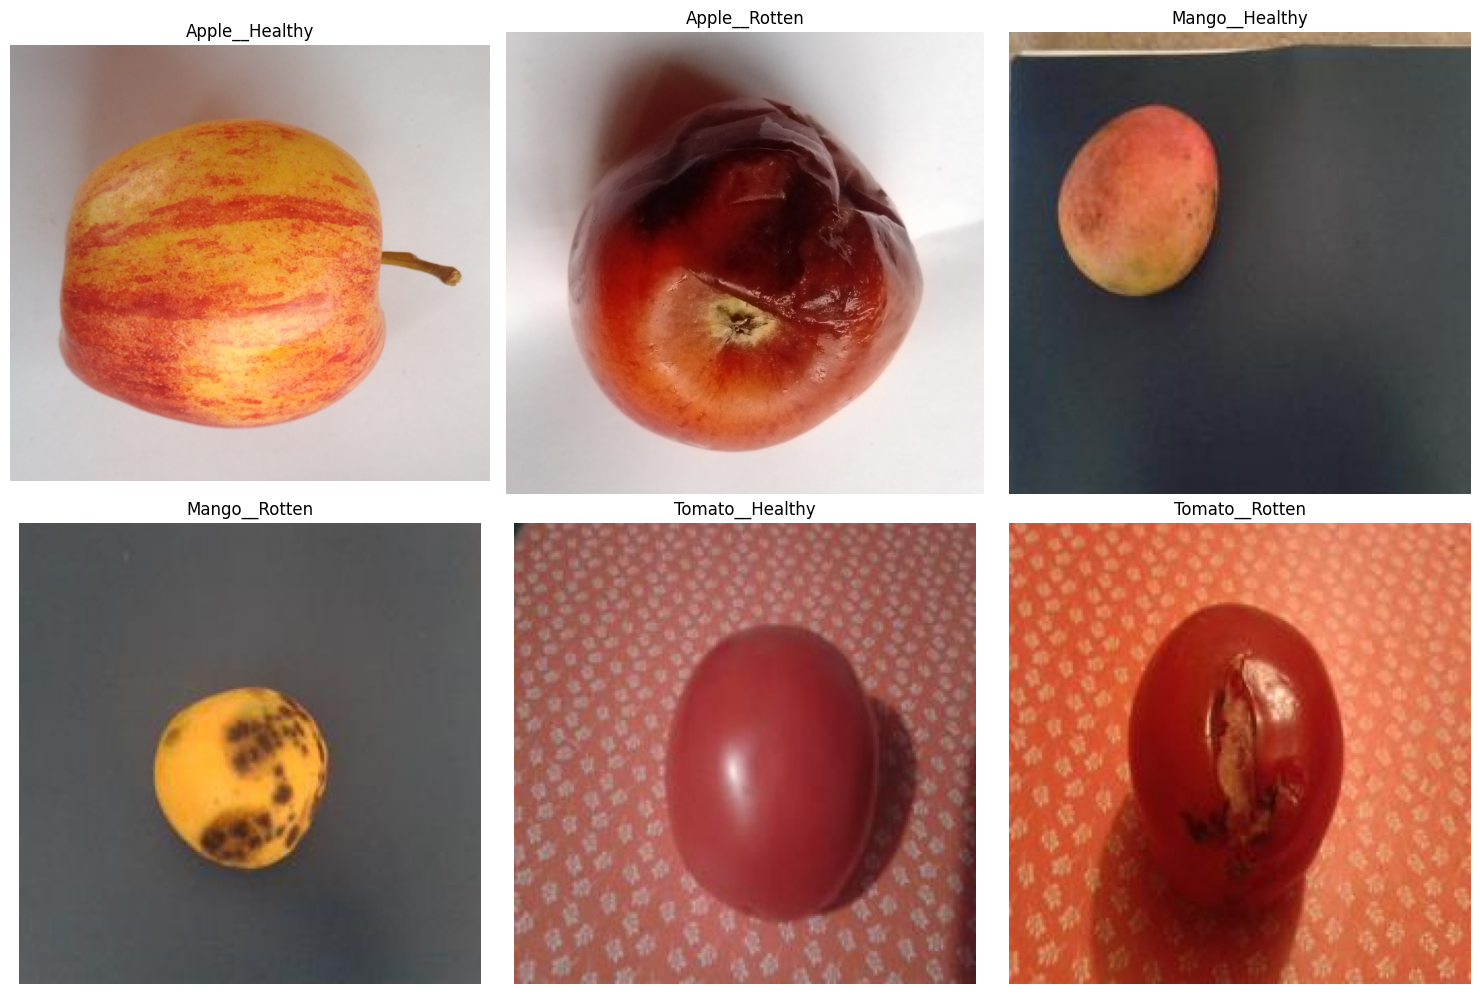

In [5]:
helper_utils.plot_samples_from_dataset(dataset_path)

<a id='3'></a>
## 3 - Fruit Guard Pro Pre Trained Model

Here, you load a pre-trained Fruit Guard Pro model and inspect its structure. The model is built on ResNet50 but has been modified for binary classification — fresh vs. rotten fruit — by replacing its final layer with one that outputs two values. The saved weights are then loaded so the model is ready to make predictions without training from scratch.


In [6]:
# Loading the FruitGuard Pro weights in a model based on ResNet-50

net = helper_utils.load_model("./data/fruit_guard_pro.pth", device)

Starting loading model...
Changing the final layer to a binary classification layer...
Loading the model weights...
Loading the model weights into the model...
Model loaded successfully!


Once loaded, you print the architecture layer by layer, showing each layer’s name, type, and number of parameters. For sequential blocks, you also drill down into their sub-layers. This helps you see how the network processes images, from early convolutional layers that capture small details to deeper layers that combine those into larger patterns.

In [7]:
# Print the model architecture

helper_utils.print_model_architecture(net)


Layer-wise Details:
--------------------------------------------------------------------------------
Layer: conv1                (Conv 7x7)      Parameters: 9,408
Layer: bn1                                  Parameters: 128
Layer: relu                                 Parameters: 0
Layer: maxpool                              Parameters: 0
Layer: layer1                               Parameters: 215,808
  └─ 0                                  Parameters: 75,008
  └─ 1                                  Parameters: 70,400
  └─ 2                                  Parameters: 70,400
Layer: layer2                               Parameters: 1,219,584
  └─ 0                                  Parameters: 379,392
  └─ 1                                  Parameters: 280,064
  └─ 2                                  Parameters: 280,064
  └─ 3                                  Parameters: 280,064
Layer: layer3                               Parameters: 7,098,368
  └─ 0                                  Paramet

Understanding this structure is key for the next steps — activation visualization, saliency maps, and class activation maps — because you’ll know exactly which layers to monitor. With a clear map of the model’s internals, you can choose the most informative points to analyze and interpret how the network reaches its decisions.


<a id='4'></a>
## 4 - Feature Hierarchy Visualization

In this task, you will create a function that helps visualize how different layers of the Fruit Guard Pro model transform an image as it moves deeper into the network. You'll load an image, prepare it in the right format for the model, and capture the feature maps (activations) from key layers using forward hooks.  

Your job will be to:  
- Preprocess the image so it matches the model's expected size and normalization.  
- Select important convolutional layers and attach hooks to record their outputs during a forward pass.  
- Run the image through the model to collect these activations.  
- Return the captured feature maps so they can be used for visualization and to understand the model's feature hierarchy and receptive fields.  

By completing this, you'll see how the network's early layers capture fine details, while deeper layers respond to more complex and abstract patterns.

Let's start.

-------------

The following helper function creates a forward hook that stores the output (activation) of a specific layer during a model’s forward pass. When you call `grab(activations, name)`, it returns a hook function that, once attached to a layer, will save that layer’s output tensor into the `activations` dictionary under the given `name`. The `.detach()` method is used to remove the tensor from the computation graph so it won’t track gradients, which saves memory and makes it easier to work with later.  

In short, this function lets you capture and label the feature maps from chosen layers, making it possible to inspect how the network processes an image at different stages.


In [8]:

def grab(activations, name):
    def _hook(_, __, out): 
        activations[name] = out.detach()
    return _hook

<a id='ex01'></a>
### Exercise 1

Implement ```cnn_feature_hierarchy_demo(img, model)```.

Goal: Using a pretrained FruitGuard Pro (ResNet-50 backbone) and a preprocessed input tensor, return a dictionary mapping layer names → captured feature-map tensors.

The function has the following stages:
1. Assume Preprocessed Input
   - img is already:
      + RGB
      + center-cropped to 224×224
      + normalized with ImageNet statistics (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      + shaped (1, 3, 224, 224) and placed on the same device as model.

2. Register Forward Hooks
   - Create a helper ```grab(name)``` that returns a hook storing a layer's output into ```activations[name]```.
   - Select five sampling points:
      + "conv1" → model.conv1
      + "layer1" → model.layer1[0].conv1
      + "layer2" → model.layer2[0].conv1
      + "layer3" → model.layer3[0].conv1
      + "layer4" → model.layer4[0].conv1
   - Attach hooks so that, during the forward pass, raw feature maps are recorded under those keys.

3. Forward Pass
   - Run the model under torch.no_grad():
   ```
      with torch.no_grad():
         _ = model(img)
   ```
   - Afterward, activations should look like:
   ```
      {
      "conv1":  Tensor of shape (1, C1, H1, W1),
      "layer1": Tensor of shape (1, C2, H2, W2),
      ...,
      "layer4": Tensor of shape (1, C5, H5, W5),
      }
   ```
4. Clean Up Hooks
   - Remove all registered hooks to avoid memory leaks.
5. Return
   - Return the activations dictionary.
---

The output of this function—a dictionary of feature maps—will then be used by provided code to identify the channels with the highest average activation. These selected channels will be upsampled to 224×224 and visualized side by side to reveal how the network's internal representations evolve across layers.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

### 1) Hook & registration patern
```python
   def grab(store, name):
      def _hook(module, inputs, output):
         store[name] = output.detach()
      return _hook

   activations = {}
   layers = {
      "conv1":  model.conv1,
      "layer1": model.layer1[0].conv1,
      "layer2": model.layer2[0].conv1,
      "layer3": model.layer3[0].conv1,
      "layer4": model.layer4[0].conv1,
   }

   hooks = [layer.register_forward_hook(grab(activations, n))
            for n, layer in layers.items()]
```

### 2) Forwar + cleanup
```python
   with torch.no_grad():
      _ = model(img)

   for hook in hook_array:
      hook.remove()
```
</details>

In [16]:
# GRADED FUNCTION: cnn_feature_hierarchy_demo

def cnn_feature_hierarchy_demo(img, model):
    """
    Visualise FruitGuard Pro feature hierarchy & print receptive-field stats for key layers.

    Parameters
    ----------
    img : torch.Tensor
        Tensor of an RGB image (will be centre-cropped to 224×224).
    model : torch.nn.Module
        Pretrained model to use for feature extraction.
    save_path : str | None, default = None
        If given, save the matplotlib figure to this path.
    Returns
    -------
    Dict[str, torch.Tensor]
        A dictionary mapping layer names → captured feature-map tensors.
    """

    ### START CODE HERE ###
    activations = {} # Initialize an empty dictionary to store the activations 
    layers = { # Dictionary of layers to register forward hooks for 
        "conv1": model.conv1, # Register forward hook for the first convolution layer
        "layer1": model.layer1[0].conv1, # Register forward hook for the first convolution layer in the first layer of the model
        "layer2": model.layer2[0].conv1, # Register forward hook for the first convolution layer in the second layer of the model
        "layer3": model.layer3[0].conv1, # Register forward hook for the first convolution layer in the third layer of the model
        "layer4": model.layer4[0].conv1, # Register forward hook for the first convolution layer in the fourth layer of the model
    }

    hooks = [layer.register_forward_hook(grab(activations, n)) for n, layer in layers.items()] # Register forward hooks for each layer
    ### END CODE HERE ###

    # Forward pass
    with torch.no_grad():
        _ = model(img) 

    # Remove hooks
    for h in hooks:  
        h.remove() 

    return activations

To verify your code, run the following cells!

You can test your code with different images changing the `image_path` variable. Some values that can be used are:

- ./data/fruit_subset/Apple__Rotten/rottenApple (482).jpg
- ./data/fruit_subset/Apple__Rotten/rottenApple (522).jpg
- ./data/fruit_subset/Mango__Healthy/35.jpg
- ./data/fruit_subset/Mango__Rotten/163.jpg
- ./data/fruit_subset/Tomato__Healthy/freshTomato (12).jpg
- ./data/fruit_subset/Tomato__Rotten/rottenTomato (9).jpg

You can find more images to test on in the folder ./data/fruit_subset/

In [17]:
# Set the path to the image to test your function
image_path = "./data/fruit_subset/Apple__Healthy/FreshApple (2).jpg"

Activations keys and shapes:
----------------------------------------------------------------------------------------------------
dict_keys(['conv1', 'layer1', 'layer2', 'layer3', 'layer4'])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
----------------------------------------------------------------------------------------------------


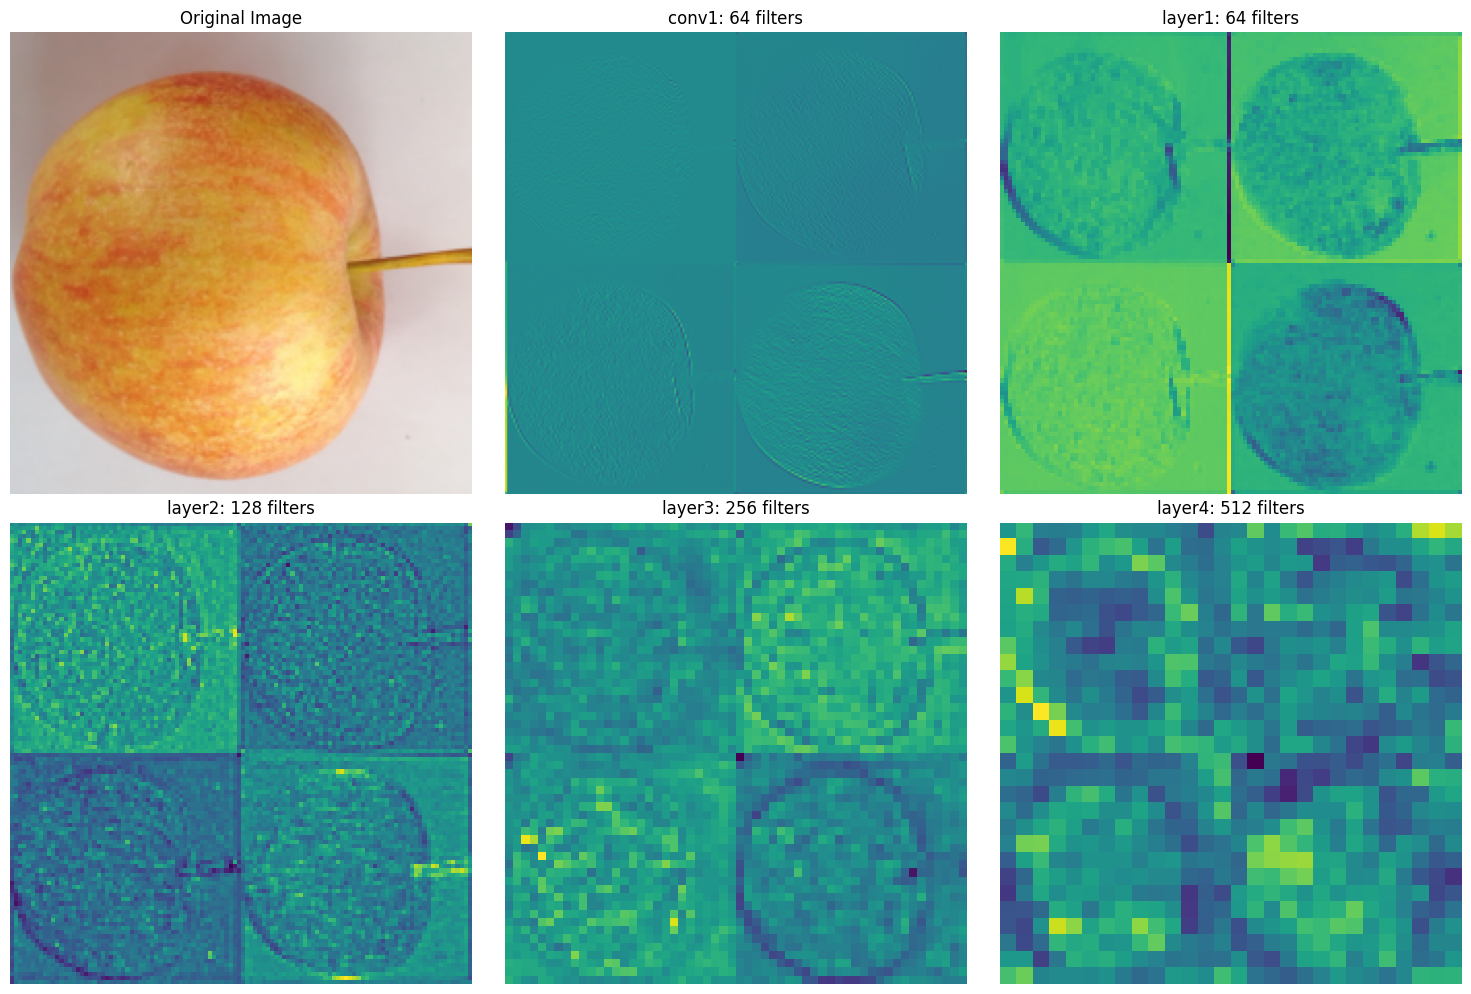

In [18]:
# Verify your implementation

img = helper_utils.preprocess_image(image_path, device)
net = net.to(device)

# Compute the activations
activations = cnn_feature_hierarchy_demo(
    img=img,
    model=net
)

# Check all keys and shapes
print("Activations keys and shapes:")
print("-"*100)
print(activations.keys())
print(activations["conv1"].shape)
print(activations["layer1"].shape)
print(activations["layer2"].shape)
print(activations["layer3"].shape)
print(activations["layer4"].shape)
print("-"*100)

# Display the feature hierarchy for the given image
helper_utils.display_feature_hierarchy(activations, image_path)

#### Expected Output:

```
Activations keys and shapes:
----------------------------------------------------------------------------------------------------
dict_keys(['conv1', 'layer1', 'layer2', 'layer3', 'layer4'])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 56, 56])
torch.Size([1, 128, 56, 56])
torch.Size([1, 256, 28, 28])
torch.Size([1, 512, 14, 14])
----------------------------------------------------------------------------------------------------
```
The displayed image should look something like the following, notice that it will change if you use a different sample image:
# ![Expected Output](./images/exercise1_expected.jpg)



In [19]:
# Test your code!

unittests.exercise_1(cnn_feature_hierarchy_demo)

 All tests passed!


<a id='5'></a>
## 5 - Feature Map Strip

In this task, you will build a compact visual summary that shows the strongest responding feature at five depths of the model. You will pass forward an already-preprocessed image tensor through the model, capture feature maps from selected layers, pick the most active channel at each depth, upsample it to 224×224, and return a list of five single-channel tensors suitable for side-by-side visualization.

Your job will be to:
- Attach forward hooks on `conv1` and the first convolution of `layer1`, `layer2`, `layer3`, and `layer4` to capture their feature maps during a forward pass.
- Run the forward pass to populate the captured maps and then remove the hooks.
- For each captured map, identify the channel with the highest mean activation, select it, upsample it to 224×224 with bilinear interpolation, and normalize the values to a 0–1 range.
- Return the ordered list of the five upsampled tensors so they can be visualized as a feature map strip.

By completing this, you will get a quick, interpretable snapshot of how the model's focus shifts from simple edge and texture responses toward more abstract patterns as depth increases.

Let's start.


<a id='ex02'></a>
### Exercise 2

Implement a function that, given an RGB image and the pretrained Fruig Guard Pro model, returns a **list** of five 4D tensors—one per sampled layer—each upsampled to 224×224 and normalized to [0, 1].

The function follow the followin stages:

1. Capture feature maps with forward hooks
   - Register hooks on:
      + model.conv1
      + model.layer1[0].conv1
      + model.layer2[0].conv1
      + model.layer3[0].conv1
      + model.layer4[0].conv1
   - Each hook should store its output (detached to CPU) in a dict (e.g., feats) under the keys: "conv1", "layer1", "layer2", "layer3", "layer4".
   - Use a grab function to register forward hooks

2. Forward pass (no grads)
   - Run with torch.no_grad(): _ = model(img) to populate feats, then remove all hooks to avoid leaks.

3. Select, upsample, and normalize the top channel per layer
   - For each of the five keys in order:
      + Compute the per-channel mean over spatial dims: fm.mean((2, 3)).
      + Take the index of the highest mean activation.
      + Select that channel while keeping the channel dimension: fm[:, idx:idx+1].
      + Upsample to (224, 224) using bilinear interpolation with align_corners=False.
      + Min–max normalize to [0, 1] with a small epsilon (1e-8) to avoid divide-by-zero.
4. Return value
   - Return an ordered list of five tensors (one per depth), each shaped (1, 1, 224, 224), corresponding to:
   ["conv1", "layer1", "layer2", "layer3", "layer4"].

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

#### **Define Grab Function**
```python
   def grab(name):
      # Add key name to feats and store the output, detach and move to cpu.
      return lambda _m, _i, out: feats.setdefault(name, out.detach().cpu())
```

#### **Register forward hooks**
```python
   hooks = [
         model.conv1.register_forward_hook(grab("conv1")), 
         model.layer1[0].conv1.register_forward_hook(grab("layer1")), 
         .
         .
         .
   ]
```

#### Forward Pass and Remove Hooks
```python
# Forward pass
   with torch.no_grad():
      _ = model(img)
   
   # Remove hooks
   for h in hooks: 
      h.remove()
```

#### Select, upsample and normalize
```python
   # Capture channel with highest mean activation and upsample feature maps
    upsampled = []
    
    for name in ["conv1", "layer1", "layer2", "layer3", "layer4"]: 
        fm = feats[name]
        # Get the index of the max channel
        sel = fm[:, idx:idx+1]
        .
        .
        .
```
</details>

In [23]:
# GRADED FUNCTION: feature_map_strip

def feature_map_strip(img, model):
    """
    Forward-pass an image through pretrained ResNet-50, capture the feature map
    with the highest mean activation at five depths, upsample them and returns a
    list of five upsampled tensors.

    Parameters
    ----------
    img : torch.Tensor
        Tensor of an RGB image (will be centre-cropped to 224×224).
    model : torch.nn.Module
        Pretrained model to use for feature extraction.
    Returns
    -------
    Dict[str, torch.Tensor]
        Dictionary of raw feature maps for keys
        {"conv1", "layer1", "layer2", "layer3", "layer4"}.
    """

    ### START CODE HERE ###
    
    # Set model to evaluation mode
    model.eval() 
    
    # Get feature maps
    feats = {} # Initialize an empty dictionary to store the activations

    # Register forward hooks
    def grab(name):
        # Add key name to feats and store the output, detach and move to cpu.
        def _hook(_m, _i, out): 
            # Detach the tensor, move to CPU, and store it
            feats[name] = out.detach().cpu()
        return _hook

    hooks = [ # Register forward hooks for each layer
        model.conv1.register_forward_hook(grab("conv1")), # Register forward hook for the first convolution layer
        model.layer1[0].conv1.register_forward_hook(grab("layer1")), # Register forward hook for the first convolution layer in the first layer of the model
        model.layer2[0].conv1.register_forward_hook(grab("layer2")), # Register forward hook for the first convolution layer in the second layer of the model
        model.layer3[0].conv1.register_forward_hook(grab("layer3")), # Register forward hook for the first convolution layer in the third layer of the model
        model.layer4[0].conv1.register_forward_hook(grab("layer4")), # Register forward hook for the first convolution layer in the fourth layer of the model
    ]

    # Forward pass
    with torch.no_grad():
        _ = model(img) # Forward pass the image through the model
    
    # Remove hooks
    for h in hooks: 
        h.remove() # Remove the forward hook

    # Capture channel with highest mean activation and upsample feature maps
    upsampled = [] # Initialize an empty list to store the upsampled feature maps
    
    for name in ["conv1", "layer1", "layer2", "layer3", "layer4"]:
        fm = feats[name] # Get the feature map for the <<name>> layer
        idx = fm.mean(dim=(2, 3)).argmax() # Get the index of the channel with the highest mean activation
        sel = fm[:, idx:idx+1] # Select the channel with the highest mean activation
        sel = F.interpolate(
            sel,
            size=(224, 224),
            mode="bilinear",
            align_corners=False,
        ) # Upsample the feature map to 224x224
        min_val = sel.min()
        max_val = sel.max()
        sel = (sel - min_val) / (max_val - min_val + 1e-8) # Normalize the feature map
        upsampled.append(sel) # Append the upsampled feature map to the list
    ### END CODE HERE ###

    return upsampled

To verify your code, run the following cells!

You can test your code with different images changing the `image_path` variable. Some values that can be used are:

- ./data/fruit_subset/Apple__Rotten/rottenApple (482).jpg
- ./data/fruit_subset/Apple__Rotten/rottenApple (522).jpg
- ./data/fruit_subset/Mango__Healthy/35.jpg
- ./data/fruit_subset/Mango__Rotten/163.jpg
- ./data/fruit_subset/Tomato__Healthy/freshTomato (12).jpg
- ./data/fruit_subset/Tomato__Rotten/rottenTomato (9).jpg

You can find more images to test on in the folder ./data/fruit_subset/

In [24]:
# Set the path to the image to test the feature map strip function
image_path = "./data/fruit_subset/Apple__Healthy/FreshApple (2).jpg"

Shape of the upsampled feature maps:
------------------------------------------------------------------------------------------------------------
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
------------------------------------------------------------------------------------------------------------


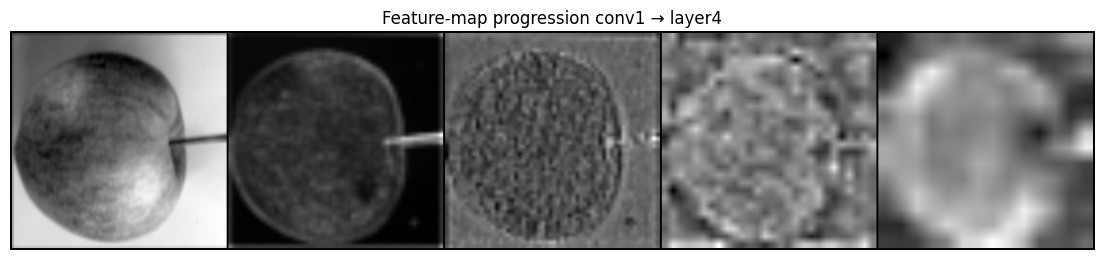

In [25]:
# Verify your implementation

img = helper_utils.preprocess_image(image_path)
net = net.to("cpu")
# Display the feature hierarchy for the given image
upsampled = feature_map_strip(img, net)

print("Shape of the upsampled feature maps:")
print("-"*108)
print(upsampled[0].shape)
print(upsampled[1].shape)
print(upsampled[2].shape)
print(upsampled[3].shape)
print(upsampled[4].shape)
print("-"*108)

helper_utils.visual_strip(upsampled)

#### Expected Output:
```
Shape of the upsampled feature maps:
------------------------------------------------------------------------------------------------------------
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
------------------------------------------------------------------------------------------------------------
```
Notice that the displayed image might be different if you use a different input image.
# ![Expected Output](./images/solution2.jpg)


In [26]:
# Test your code!

unittests.exercise_2(feature_map_strip)

 All tests passed!


<a id='6'></a>
## 6 - Saliency Map

In this exercise, you will implement a function that highlights which pixels in an input image most influence a model's score for a specific class. The result is a saliency heatmap: brighter values indicate pixels where small changes would most affect the chosen class score. This gives you a fine-grained view of what the network is sensitive to at the input level and helps you verify that attention is on the fruit rather than background clutter.

<a id='ex03'></a>
### Exercise 3

Your job will be to implement the function ```saliency_map(model, image_tensor, class_idx)```.
- Make sure gradients flow to the input by working with a leaf tensor that has `requires_grad=True`.
- Run a forward pass to obtain the logits and select the target class score using `class_idx`.
- Zero existing gradients and backpropagate from the selected logit to the input.
- Take the absolute value of the input gradients and reduce over the color channels to get a single 2-D map.
- Normalize the map to the range [0, 1] and return it for visualization or overlay later.

By completing this, you'll produce a clear, pixel-level explanation of the model's sensitivity for a chosen class, a helpful complement to the deeper, region-level views you will build in later steps.


<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>
1. **Prepare the Input for Gradients**  
   - Take the provided `image_tensor` (shape `(1, 3, H, W)`) and ensure it is a leaf tensor with `requires_grad=True`.  
   - Hint: use `.clone().detach().requires_grad_(True)`.

2. **Forward Pass & Select Target Logit**  
   - Run the model on the input to get `output` (shape `(1, num_classes)`).  
   - Extract the scalar logit at `[0, class_idx]` as `target_logit`.

3. **Backward Pass**  
   - Zero any existing gradients on the model via `model.zero_grad()`.  
   - Call `target_logit.backward()` to compute gradients of the logit w.r.t. each input pixel.

4. **Compute Saliency Map**  
   - Access `image_tensor.grad` of shape `(1, 3, H, W)`.  
   - Take the absolute value and sum over the color channel dimension → results in a 2D tensor of shape `(H, W)`.

5. **Normalize to [0, 1]**  
   - Subtract the minimum, then divide by `(max + ε)` to scale all values into the [0,1] range.

6. **Return Value**  
   - Return the final 2D heatmap tensor of shape `(H, W)`, detached from the graph.
</details>

In [30]:
# GRADED FUNCTION: saliency_map

def saliency_map(model, image_tensor, class_idx):
    """
    Generate a saliency map for a single image and class.

    Parameters
    ----------
    model : torch.nn.Module
        A *trained* CNN; should already be in `.eval()` mode.
    image_tensor : torch.Tensor
        Input tensor with shape (1, 3, H, W).  Must be a **leaf tensor** and
        pre-processed the same way the model expects (e.g., ImageNet normalisation).
    class_idx : int
        Index of the target class logit to explain.
    Returns
    -------
    torch.Tensor
        A 2-D saliency heat-map normalised to the range [0, 1] with shape (H, W).
    """ 

    ### START CODE HERE ###

    # Ensure gradients flow to the input
    input_grad = image_tensor.clone().detach().requires_grad_(True) # Make a copy of the image tensor
    image_tensor = input_grad # detach the image tensor
    image_tensor.requires_grad_(True) # Set requires grad to True

    # Forward pass
    output = model(input_grad) # Forward pass the image through the model
    target_logit = output[0, class_idx] # Get the target logit assume class_idx is the index of the target class

    # Backward pass – gradient w.r.t. input pixels
    model.zero_grad() # Zero gradients
    target_logit.backward() # Backward pass to compute gradients

    # Absolute gradient, sum over colour channels
    grads = input_grad.grad.abs().sum(dim=1).squeeze(0) # Absolute gradient, sum over colour channels

    # Normalise to [0, 1]
    # grads = (grads - min) / (max + epsilon) 
    grads -= grads.min()
    grads /= grads.max() - grads.min() + 1e-8 # Use epslon as a small number (1e-8)to avoid division by zero

    ### END CODE HERE ###

    heatmap = grads  # alias for clarity

    return heatmap.detach()

To verify your code, run the following cells!

You can test your code with different images changing the `image_path` variable. Some values that can be used are:

- ./data/fruit_subset/Apple__Rotten/rottenApple (482).jpg
- ./data/fruit_subset/Apple__Rotten/rottenApple (522).jpg
- ./data/fruit_subset/Mango__Healthy/35.jpg
- ./data/fruit_subset/Mango__Rotten/163.jpg
- ./data/fruit_subset/Tomato__Healthy/freshTomato (12).jpg
- ./data/fruit_subset/Tomato__Rotten/rottenTomato (9).jpg

You can find more images to test on in the folder ./data/fruit_subset/

In [31]:
# Set the path to the image
image_path = "./data/fruit_subset/Apple__Rotten/rottenApple (1).jpg"

Starting loading model...
Changing the final layer to a binary classification layer...
Loading the model weights...
Loading the model weights into the model...
Model loaded successfully!
Shape and range of the heatmap:
----------------------------------------------------------------------------------------------------
shape = torch.Size([224, 224])
min = 0.0, max = 1.0
----------------------------------------------------------------------------------------------------


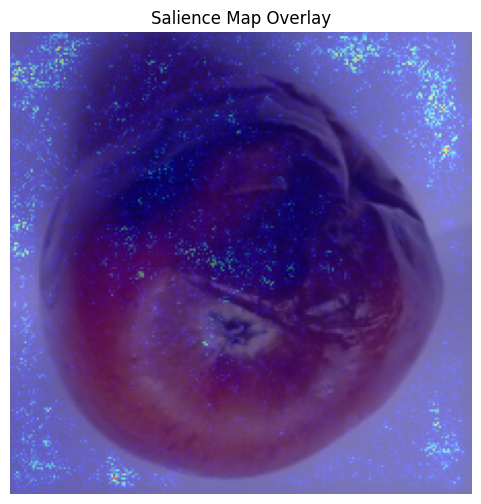

In [32]:
# Test saliency map

# Open image and transform to processed tensor
image_tensor = helper_utils.preprocess_image(image_path)
net = helper_utils.load_model("./data/fruit_guard_pro.pth")
# Set class index to 1 (rotten)
# See why the net thinks the image is from a rotten fruit!!!
class_idx = 1

heatmap = saliency_map(
    model=net,
    image_tensor=image_tensor,
    class_idx=class_idx
)


print("Shape and range of the heatmap:")
print("-"*100)
print(f"shape = {heatmap.shape}")
print(f"min = {heatmap.min()}, max = {heatmap.max()}")
print("-"*100)

helper_utils.display_saliency(image_tensor=image_tensor, heatmap=heatmap)

#### Expected Output:
```
Shape and range of the heatmap:
----------------------------------------------------------------------------------------------------
shape = torch.Size([224, 224])
min = 0.0, max = 1.0
----------------------------------------------------------------------------------------------------
```
Notice that the displayed image might be different if you use a different input image.
# ![Expected Output](./images/solution3.jpg)

---

**Interpreting Saliency Maps: What to Look For**

When examining saliency maps, keep these interpretation guidelines in mind:

1. **Focus of Attention**: Bright regions indicate pixels that strongly influence the model's prediction for the target class. For a "rotten" classification, you should see highlights on damaged or discolored areas of the fruit.

2. **Expected Behavior**: A well-trained model should highlight relevant features (e.g., brown spots, mold, holes) rather than background or irrelevant texture. If the saliency focuses on the background, the model might be using spurious correlations.

3. **Noise vs. Signal**: Saliency maps can be noisy—you'll often see scattered bright pixels. The overall pattern matters more than individual pixels. Look for coherent regions rather than random noise.

4. **Complementary to CAM**: Saliency maps show pixel-level sensitivity (fine-grained), while CAM shows region-level importance (coarse-grained). Use both together for complete understanding—saliency tells you *exactly which pixels*, CAM tells you *which general areas*.

5. **Limitations**: 
   - Saliency maps show sensitivity, not necessarily causation
   - Different classes may produce different patterns for the same image
   - Sharp edges often appear salient even if not semantically important

**Try this:** Compare saliency maps for class 0 (fresh) vs class 1 (rotten) on the same image to see what distinguishes them!

In [33]:
# Test your code!

unittests.exercise_3(saliency_map)

 All tests passed!


<a id='7'></a>
## 7 - Simplified Class Activation Map (CAM)

In this exercise, you will implement a compact version of Class Activation Mapping to highlight which regions of an image most support a chosen class score. Instead of gradients, you will combine the final convolutional feature maps with the corresponding row of the fully connected layer to produce a class-specific heatmap that you can overlay on the input.

**Why "Simplified" CAM?**  
This implementation is called "simplified" because it assumes the model architecture uses Global Average Pooling (GAP) followed by a fully connected layer, which is the case for our ResNet-50-based FruitGuard Pro model. The original CAM technique relies on this specific architecture pattern. For models with different architectures, **Grad-CAM** (Gradient-weighted Class Activation Mapping) is a more general approach that uses gradients instead of direct weight mapping and works with any CNN architecture. Both techniques produce similar visualizations, but Grad-CAM is more flexible and doesn't require the GAP→FC pattern.

<a id='ex04'></a>
### Exercise 4

Implement the ```simplified_cam``` function:
- Capture the final convolutional feature maps by attaching a forward hook to the last conv layer of the backbone.
- Run a forward pass to fill a holder with those feature maps, then remove the hook.
- Fetch the weight vector from the classification layer for `class_idx`.
- Compute a weighted sum across channels (one weight per channel) to form the raw activation map.
- Keep only positive evidence with a ReLU, then scale the map to the [0, 1] range.
- Upsample the map to the input image size and return the 2-D heatmap tensor.

By completing this, you will produce a clear, region-level view of the evidence the model uses for a specific class, complementing the pixel-level sensitivity you obtained with saliency maps.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

#### 1) Implement the aux function save_fmap
Detach the output and stor it in the feature map holder
```python
def save_fmap(_, _, output):
    fmap_holder["feat"] = output.detach()
```

#### 2) Register forward hooks and populate them wit a forward pass
```python
hook = model.layer4[-1].conv3.register_forward_hook(save_fmap)
# Forward pass
with torch.no_grad():
    _ = model(image_tensor)
```

#### 3) Retrieve features and weighted sum over channels
```python
feats = fmap_holder["feat"]              
weight_vec = model.fc.weight[class_idx]  

# Weighted sum over channels
cam = torch.einsum("c,chw->hw", weight_vec, feats.squeeze(0)) # Weighted sum over channels
```

#### 4) Normalize the positive evidence to [0, 1]
```python
cam = F.relu(cam) 
cam = (cam - cam.min()) / (cam.max() + 1e-8)
```

#### 5) Upsample cam
```python
H, W = image_tensor.shape[2:]
cam_up = F.interpolate( 
    cam.unsqueeze(0).unsqueeze(0),
    size=(H, W), 
    mode="bilinear",
    align_corners=False,
)[0, 0]
```
</details>

In [46]:
# GRADED FUNCTION: simplified_cam

def simplified_cam(model, image_tensor, class_idx):
    """
    Generate a simplified Class Activation Map (CAM) for a single image.

    Parameters
    ----------
    model : torch.nn.Module
        A trained ResNet-50-style network (final conv features → `model.fc`).
    image_tensor : torch.Tensor
        Input tensor of shape (1, 3, H, W) already normalised as the model expects.
    class_idx : int
        Index of the target class logit.

    Returns
    -------
    torch.Tensor
        2-D CAM heat-map scaled to [0, 1] with shape (H, W).
    """

    ### START CODE HERE ###

    # Capture final convolutional feature maps
    fmap_holder = {} # Initialize an empty dictionary to store the feature maps

    def save_fmap(_, __, output): # Aux function to save the feature maps
        fmap_holder["feat"] = output.detach() # Detach the output and store it in the feature map holder

    hook = model.layer4[-1].conv3.register_forward_hook(save_fmap) # Register forward hook for the last convolution layer

    ### END CODE HERE ###

    # Forward pass
    with torch.no_grad():
        _ = model(image_tensor) # Forward pass the image through the model

    hook.remove() # Remove the forward hook

    ### START CODE HERE ###
    # Retrieve features and FC weights
    feats = fmap_holder["feat"] # (1, 512, 7, 7)
    weight_vec = model.fc.weight[class_idx] # (512,)

    # Weighted sum over channels
    # 'c': weight per channel, 'chw': feature maps (c=channels, h=height, w=width)
    # compute activation map summed over channels
    cam = torch.einsum("c,chw->hw", weight_vec, feats.squeeze(0)) # Weighted sum over channels

    # Keep positive evidence, normalise to [0,1]
    cam = F.relu(cam) # Keep positive evidence 0 if negative, same if positive
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8) # Normalize to [0,1] (cam - min) / (max - min + epsilon)

    # Upsample to input size
    H, W = image_tensor.shape[2:] # Get the height and width of the input image
    cam_up = F.interpolate( # Upsample the activation map to the input size 
        cam.unsqueeze(0).unsqueeze(0), # Add batch and channel dimensions
        size=(H, W), # Set the size of the output activation map
        mode="bilinear", # Use bilinear interpolation
        align_corners=False, # Set align_corners to False
    )[0, 0]

    ### END CODE HERE ###

    return cam_up.cpu().detach()

To verify your code, run the following cells!

You can test your code with different images changing the `image_path` variable. Some values that can be used are:

- ./data/fruit_subset/Apple__Rotten/rottenApple (482).jpg
- ./data/fruit_subset/Apple__Rotten/rottenApple (522).jpg
- ./data/fruit_subset/Mango__Healthy/35.jpg
- ./data/fruit_subset/Mango__Rotten/163.jpg
- ./data/fruit_subset/Tomato__Healthy/freshTomato (12).jpg
- ./data/fruit_subset/Tomato__Rotten/rottenTomato (9).jpg

You can find more images to test on in the folder ./data/fruit_subset/

In [47]:
image_path = "./data/fruit_subset/Apple__Rotten/rottenApple (1).jpg"

In [48]:
# Verify the CAM

# Load image tensor and preprocess
image_tensor = helper_utils.preprocess_image(image_path)

# Compute CAM
cam_up = simplified_cam(net, image_tensor, class_idx)

print("Shape and range of the CAM:")
print("-"*100)
print(f"shape = {cam_up.shape}")
print(f"min = {cam_up.min()}, max = {cam_up.max()}")
print("-"*100)

helper_utils.display_cam(image_tensor, cam_up)

NameError: name 'out' is not defined

#### Expected Output:
```
Shape and range of the CAM:
----------------------------------------------------------------------------------------------------
shape = torch.Size([224, 224])
min = 0.0, max = 0.9915805459022522
----------------------------------------------------------------------------------------------------
```
Notice that the displayed image might be different if you use a different input image.
# ![Expected Output](./images/solution4.jpg)

In [49]:
# Test your code!
unittests.exercise_4(simplified_cam)

 All tests passed!


---

<a id='8'></a>
## 8 - Comparison of Interpretability Techniques

You've now implemented three powerful techniques for understanding model behavior. Here's how they compare:

| **Aspect** | **Feature Hierarchy** | **Saliency Maps** | **Class Activation Maps (CAM)** |
|------------|----------------------|-------------------|--------------------------------|
| **What it shows** | Evolution of features across layers | Pixel-level gradient sensitivity | Region-level class evidence |
| **Granularity** | Layer-by-layer channel responses | Individual pixels | Coarse spatial regions |
| **Computation** | Forward hooks only | Backpropagation to input | Forward hooks + FC weights |
| **Speed** | Fast ⚡ | Medium ⏱️ | Fast ⚡ |
| **Use case** | Understanding feature learning | Finding important pixels | Localizing class evidence |
| **Output** | Multiple feature maps | Single heatmap per class | Single heatmap per class |
| **Requires gradients?** | No | Yes | No |
| **Architecture constraints** | None | None | Requires GAP→FC (or use Grad-CAM) |
| **Best for** | Model debugging, visualization | Adversarial analysis, fine details | Model trustworthiness, localization |

**When to use each:**

- **Feature Hierarchy**: Use when you want to understand *how* a model learns, what patterns emerge at different depths, or debug training issues.
  
- **Saliency Maps**: Use when you need *precise pixel-level explanations*, are concerned about adversarial vulnerabilities, or want to understand fine-grained sensitivities.
  
- **CAM/Grad-CAM**: Use when you need *human-interpretable region highlights*, want to verify the model is looking at the right object, or need coarse localization for weakly-supervised tasks.

**Pro Tip**: Combine multiple techniques! For example:
1. Use **CAM** to verify the model focuses on the fruit (not background)
2. Use **Saliency** to see exactly which pixels (e.g., specific spots, edges) drive the decision
3. Use **Feature Hierarchy** to understand what low/mid/high-level features the model learned

This multi-method approach gives you comprehensive understanding of your model's behavior.

---
# Submission Note

Congratulations! You've completed the final graded exercise of this assignment.

If you've successfully passed all the unit tests above, you've completed the core requirements of this assignment. Feel free to [submit](#submission) your work now. The grading process runs in the background, so it will not disrupt your progress and you can continue on with the rest of the material.

**🚨 IMPORTANT NOTE** If you have passed all tests within the notebook, but the autograder shows a system error after you submit your work:

<div style="background-color: #1C1C1E; border: 1px solid #444444; color: #FFFFFF; padding: 15px; border-radius: 5px;">
    <p><strong>Grader Error: Grader feedback not found</strong></p>
    <p>Autograder failed to produce the feedback...</p>
</div>
<br>

This is typically a temporary system glitch. The most common solution is to resubmit your assignment, as this often resolves the problem. Occasionally, it may be necessary to resubmit more than once. 
>
If the error persists, please reach out for support in the [DeepLearning.AI Community Forum](https://community.deeplearning.ai/c/course-q-a/pytorch-for-developers/pytorch-advanced-architectures-and-deployment/562).

---

<a id='9'></a>
## 9 - Optional: Text-to-Image Generation

**From Interpretation to Creation**

So far, you've been analyzing how models *interpret* existing images—visualizing feature hierarchies, identifying important pixels with saliency maps, and highlighting class-specific regions with CAM. These techniques help you understand what a trained model "sees" and how it makes decisions.

Now, we shift perspective: instead of analyzing how models process images, you'll explore how they can *create* new ones from scratch. This transition from **interpretation to generation** demonstrates the full power of deep learning—models that not only understand visual patterns but can also synthesize new images based on learned representations.

In this optional section, you'll work with **Stable Diffusion**, a state-of-the-art text-to-image model that uses diffusion processes to gradually refine random noise into coherent images guided by text prompts. This connects back to the interpretability work you've done: understanding how models process features helps you better control what they generate.

---

<a id='9-1'></a>
### 9.1 - Optional Exercise: Text-to-Image Generation

In this optional exercise, you will implement `generate_sd_image` to synthesize an image from a text prompt using a pre-trained Stable Diffusion pipeline. The model will be loaded from a **local `.models` folder** to avoid downloading from the internet each time. This gives you practice with prompt design, negative prompts, deterministic sampling with seeds, and saving outputs in a clear directory structure.

### What you will do
- Select the compute device and data type based on CUDA availability.
- Load the Stable Diffusion pipeline using a local cache directory (`.models`).
- Create a `torch.Generator` on the chosen device and set a manual seed for reproducible outputs.
- Call the pipeline with `prompt`, `negative_prompt`, and `num_inference_steps` to generate one image.
- Build a save path of the form `synthetic/<slugified_prompt>/img_<seed>.png`, create the folder if it does not exist, and save the PNG.
- Return the generated `PIL.Image.Image` and print where it was saved.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

#### 1) Set the appropriate device and data type
Set `device = "cuda" if torch.cuda.is_available() else "cpu"` and choose `dtype = torch.float16` on CUDA, otherwise `torch.float32`.

#### 2) Load the pipeline with cache_dir:
```python
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-base",  # Model ID
    torch_dtype=dtype,
    cache_dir=".models"  # Use local .models folder as cache
).to(device)
```

#### 3) Create a seeded generator:
```python
generator = torch.Generator(device).manual_seed(seed)
```

#### 4) Generate one image:
```python
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=steps,
    generator=generator,
).images[0]
```
</details>

In [51]:
# EDITABLE CELL

def generate_sd_image(prompt, negative_prompt, seed, steps, model_id="stabilityai/stable-diffusion-2-base", save_dir="synthetic"):
    """
    Generate a single image with Stable Diffusion using a local cache.

    Parameters
    ----------
    prompt : str
        Positive text prompt.
    negative_prompt : str | None
        Negative prompt; pass None for none.
    seed : int
        Random seed for deterministic output.
    steps : int
        Number of inference steps.
    model_id : str
        HuggingFace model ID (default: "stabilityai/stable-diffusion-2-base").
    save_dir : str
        Root directory to save the PNG.

    Returns
    -------
    PIL.Image.Image
        The generated image.
    """
    ### START CODE HERE ###
    device = None
    dtype = None

    # Load the pipeline with cache_dir to use local .models folder
    pipe = StableDiffusionPipeline.from_pretrained( 
        model_id, # Set the model ID
        torch_dtype=dtype, # Set the data type
        variant="fp16", # Set variant="fp16"
        cache_dir=".models" # Set cache_dir=".models"
    ).to(device)

    generator = torch.Generator(device=device).manual_seed(seed) # Get the generator use manual seed and torch.Generator in the device
    
    # Generate the image use a pipeline
    image = pipe( 
        prompt=prompt, # Set the prompt
        negative_prompt=negative_prompt, # Set the negative prompt
        num_inference_steps=steps, # Set the number of inference steps
        generator=generator, # Set the generator
    ).images[0]

    ### END CODE HERE ###

    # Build path: synthetic/<slugified_prompt>/img_seed.png
    slug = "_".join(prompt.lower().split()[:3]) # Slugify the prompt
    out_dir = Path(save_dir) / slug # Get the output directory
    out_dir.mkdir(parents=True, exist_ok=True) # Create the output directory
    out_path = out_dir / f"img_{seed}.png" # Get the output path
    image.save(out_path)# Save the image

    print(f"Image saved to {out_path}") # Print the output path

    return image

<details>
<summary><b><font color="green">Solution to the exercise.</font></b></summary>

In case you want to see the solution:

```python

def generate_sd_image(prompt, negative_prompt, seed, steps, model_id="stabilityai/stable-diffusion-2-base", save_dir="synthetic"):
    ### START CODE HERE ###
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float16 if device == "cuda" else torch.float32

    # Load the pipeline with cache_dir to use local .models folder
    pipe = StableDiffusionPipeline.from_pretrained( 
        model_id, # Set the model ID
        torch_dtype=dtype, # Set the data type
        cache_dir=".models" # Use .models folder as cache directory
    ).to(device)

    generator = torch.Generator(device).manual_seed(seed) # Get the generator use manual seed and torch.Generator in the device

    # Generate the image use a pipeline
    image = pipe( 
        prompt=prompt, # Set the prompt
        negative_prompt=negative_prompt, # Set the negative prompt
        num_inference_steps=steps, # Set the number of inference steps
        generator=generator, # Set the generator
    ).images[0]

    ### END CODE HERE ###

    # Build path: synthetic/<slugified_prompt>/img_seed.png
    slug = "_".join(prompt.lower().split()[:3]) # Slugify the prompt
    out_dir = Path(save_dir) / slug # Get the output directory
    out_dir.mkdir(parents=True, exist_ok=True) # Create the output directory
    out_path = out_dir / f"img_{seed}.png" # Get the output path
    image.save(out_path)# Save the image

    print(f"Image saved to {out_path}") # Print the output path

    return image
```
</details>

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/1.73G [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to synthetic/a_mango_with/img_42.png


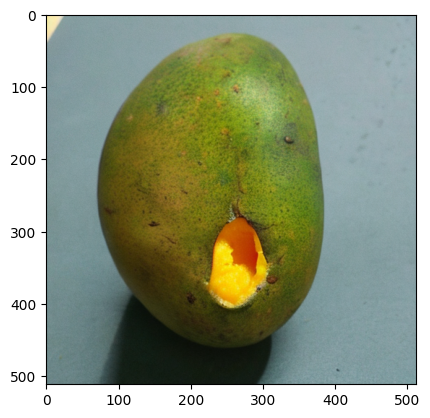

In [52]:
# Verify your code here!!

img = generate_sd_image("A mango with a small hole made by a worm in the middle.", "Fresh, intact.", 42, 50)

plt.imshow(img)

#### Expected Output:

Your generated image should look like this:

![Expected output image](./images/img_42.png)

<a id='9-2'></a>
### 9.2 - Denoising Timelapse

In this exercise, you will implement `denoising_movie` to capture snapshots of the denoising process at specific steps and assemble them into a 2×2 grid. This helps you see how noisy latents gradually turn into a coherent image as the sampler progresses. You will intercept intermediate latents via a callback, decode them to RGB with the VAE, collect the frames in order, and save a simple timelapse grid.

### What you will do
- Choose device and data type based on CUDA availability.
- Load a pre-trained Stable Diffusion pipeline using the `.models` cache directory.
- Create a seeded `torch.Generator` for deterministic sampling.
- Register a step-end callback that:
  - Checks if the current `step_idx` is in `capture_steps`.
  - Extracts `latents` from `callback_kwargs`.
  - Decodes latents to an image with the pipeline VAE and postprocesses to PIL.
  - Stores each captured frame in a dictionary keyed by `step_idx`.
- Run the pipeline with the callback enabled and collect the frames.
- Order frames to match `capture_steps`, compose a 2×2 grid, save it, and return the frames.

<details>
<summary><b><font color="green">Additional Code Hints (Click to expand if you are stuck)</font></b></summary>

#### 1) Device and dtype
```python
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32
```

#### 2) Load the Pipeline with cache_dir
```python
pipe = StableDiffusionPipeline.from_pretrained(
    model_id, 
    torch_dtype=dtype,
    cache_dir=".models"
).to(device)
```

#### 3) Prepare a frames holder and callback
```python
frames: dict[int, Image.Image] = {}

def grab_frame(pipeline, step_idx, timestep, callback_kwargs):
    if step_idx in capture_steps:
        latents = callback_kwargs["latents"]
        with torch.no_grad():
            img = pipe.vae.decode(
                latents / pipe.vae.config.scaling_factor,
                return_dict=False
            )[0]
        pil = pipe.image_processor.postprocess(img, output_type="pil")[0]
        frames[step_idx] = pil
    return callback_kwargs
```

#### 4) Torch generator and run the pipe
```python
generator = torch.Generator(device).manual_seed(seed)

_ = pipe(
    prompt=prompt,
    num_inference_steps=steps,
    generator=generator,
    callback_on_step_end=grab_frame,
)
```

</details>

In [53]:
# EDITABLE CELL

def denoising_movie(prompt, seed, steps, capture_steps, model_id="stabilityai/stable-diffusion-2-base", save_grid_path="timelapse.png"):
    """
    Capture intermediate denoising frames and assemble a 2×2 grid PNG.

    Parameters
    ----------
    prompt : str
        Positive text prompt.
    seed : int
        Random seed for deterministic sampling.
    steps : int
        Total number of inference steps.
    capture_steps : list[int]
        Which step indices to capture (e.g. [0,10,20,30]).
    model_id : str
        HuggingFace model ID (default: "stabilityai/stable-diffusion-2-base").
    save_grid_path : str
        Output path for the grid PNG.

    Returns
    -------
    list[PIL.Image.Image]
        List of captured frames in the order of `capture_steps`.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float16 if device == "cuda" else torch.float32

    ### START CODE HERE ###
    pipe = StableDiffusionPipeline.from_pretrained( 
        model_id, # Set the model ID
        torch_dtype=dtype, # Set the data type
        variant="fp16", # Set variant="fp16"
        cache_dir=".models" # Set cache_dir=".models"
    ).to(device)

    frames = {} # Initialize an empty dictionary to store the frames

    def grab_frame(pipeline, step_idx, timestep, callback_kwargs): # Aux function to grab the frame and decode the latents
        if step_idx in capture_steps: # Check if the step index is in the capture steps
            latents = callback_kwargs["latents"] # Get the latents
            with torch.no_grad():
                img = pipeline.vae.decode( # Decode the latents space from vae in pipe
                    latents / pipeline.vae.config.scaling_factor, # Divide the latents by the scaling factor
                    return_dict=False # Return the decoded image
                )[0]
            pil = pipeline.image_processor.postprocess(img, output_type="pil")[0] # Postprocess the image set the output type to pil
            frames[step_idx] = pil # Store the frame in the dictionary
        return callback_kwargs # Return the callback kwargs

    generator = torch.Generator(device=device).manual_seed(seed) # Get the generator use manual seed and torch.Generator in the device

    _ = pipe( 
        prompt=prompt, # Set the prompt
        num_inference_steps=steps, # Set the number of inference steps
        generator=generator, # Set the generator
        callback=grab_frame, # Set the callback on step end
        callback_on_step_end=True # Ensure the callback runs after each step
    )

    # Order frames according to capture_steps
    ordered_frames = [frames[s] for s in capture_steps] # Order the frames according to the capture steps

    ### END CODE HERE ###
    
    # Build grid
    w, h = ordered_frames[0].size # Get the width and height of the first frame
    grid = Image.new("RGB", (w * 2, h * 2)) # Create a new image with the width and height of the first frame
    for idx, frame in enumerate(ordered_frames): 
        row, col = divmod(idx, 2) # Get the row and column of the frame
        grid.paste(frame, (col * w, row * h)) # Paste the frame in the grid

    grid.save(save_grid_path) # Save the grid
    print(f"Timelapse grid saved to {save_grid_path}") # Print the output path

    return ordered_frames

<details>
<summary><b><font color="green">Solution to the exercise</font></b></summary>

```python
def denoising_movie(prompt, seed, steps, capture_steps, model_id="stabilityai/stable-diffusion-2-base", save_grid_path="timelapse.png"):

   ### START CODE HERE ###

    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float16 if device == "cuda" else torch.float32

    pipe = StableDiffusionPipeline.from_pretrained( 
        model_id, # Set the model ID
        torch_dtype=dtype, # Set the data type
        cache_dir=".models" # Use .models folder as cache directory
    ).to(device)

    frames: dict[int, Image.Image] = {} # Initialize an empty dictionary to store the frames

    def grab_frame(pipeline, step_idx, timestep, callback_kwargs): # Aux function to grab the frame and decode the latents
        if step_idx in capture_steps: # Check if the step index is in the capture steps
            latents = callback_kwargs["latents"] # Get the latents vector
            with torch.no_grad():
                img = pipe.vae.decode( # Decode the latents space from the vae in the pipeline
                    latents / pipe.vae.config.scaling_factor, # Divide the latents by the scaling factor
                      return_dict=False # Return the decoded image 
                )[0]
            pil = pipe.image_processor.postprocess(img, output_type="pil")[0] # Postprocess the image set the output type to pil
            frames[step_idx] = pil # Store the frame in the dictionary  
        return callback_kwargs # Return the callback kwargs

    generator = torch.Generator(device).manual_seed(seed) # Get the generator use manual seed and torch.Generator in the device

    _ = pipe(
        prompt=prompt, # Set the prompt
        num_inference_steps=steps,  # Set the number of inference steps
        generator=generator,  # Set the generator
        callback_on_step_end=grab_frame,  # Set the callback on step end
    )

    # Order frames according to capture_steps
    ordered_frames = [frames[s] for s in capture_steps] # Order the frames according to the capture steps

    ### END CODE HERE ###
    
    # Build grid
    w, h = ordered_frames[0].size # Get the width and height of the first frame
    grid = Image.new("RGB", (w * 2, h * 2)) # Create a new image with the width and height of the first frame
    for idx, frame in enumerate(ordered_frames): 
        row, col = divmod(idx, 2) # Get the row and column of the frame
        grid.paste(frame, (col * w, row * h)) # Paste the frame in the grid

    grid.save(save_grid_path) # Save the grid
    print(f"Timelapse grid saved to {save_grid_path}") # Print the output path

    return ordered_frames
```

</details>

In [54]:
# Verify your implementation

ordered_frames = denoising_movie("A healthy mango.", 42, 50, [0, 10, 20, 30, 50])

grid_image = plt.imread("timelapse.png")
plt.imshow(grid_image)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/50 [00:00<?, ?it/s]

TypeError: 'bool' object is not callable

#### Expected Output:

Your generated image should look like this:

![Expected output image](./images/timelapse.png)

---

## Conclusion

You have traced the journey of an image through different stages — from being transformed into layered feature representations, to revealing which parts of it shaped the model’s decision, and finally to generating entirely new visuals guided by patterns the model has learned. Along the way, you used tools that operate at different scales, from fine-grained pixel sensitivity to broader region-level focus, and eventually to structured creation of images from random noise. These skills give you a balanced toolkit: one that not only helps you interpret and refine models, but also lets you apply them in creative and purposeful ways.
